In [4]:
%load_ext autoreload
%autoreload 2

import os
import multiprocessing

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)

import gpjax as gpx
import blackjax
import jax
import jax.numpy as jnp
from jax import jit
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from jaxoplanet.light_curves import LimbDarkLightCurve
from corner import corner
import pickle

from jaxoplanet import orbits

from kernelsearch import describe_kernel, get_trainables
from inference import log_likelihood_function, run_inference_algorithm
from util import calculate_example_lightcurve

plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]


rng_key = jax.random.PRNGKey(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## LOAD DATA AND MODEL

In [5]:
(
    t_train,
    lc_train,
    train_mask,
    t,
    lightcurve,
    systematics,
    noise,
    mask,
) = calculate_example_lightcurve()

with open("gpmodel", "rb") as file:
    model = pickle.load(file)

describe_kernel(model)

'(Periodic * Linear * Linear) + Periodic'

## CREATE SPARSE GP

In [31]:
data = gpx.Dataset(X=t_train.reshape(-1, 1), y=lc_train.reshape(-1, 1))

In [32]:
n_inducing = 15
inducing_points = jnp.concatenate(
    [
        jnp.linspace(jnp.amin(t_train), jnp.amax(t_train), n_inducing),
        t_train[~train_mask],
    ]
).reshape(-1, 1)

In [33]:
q = gpx.variational_families.CollapsedVariationalGaussian(
    posterior=model, inducing_inputs=inducing_points
)

elbo = jit(gpx.objectives.CollapsedELBO(negative=True))

In [34]:
import optax as ox

sparse_model, history = gpx.fit(
    model=q,
    objective=elbo,
    train_data=data,
    optim=ox.adamw(learning_rate=3e-4),
    num_iters=10000,
    key=rng_key,
)

  0%|          | 0/10000 [00:00<?, ?it/s]

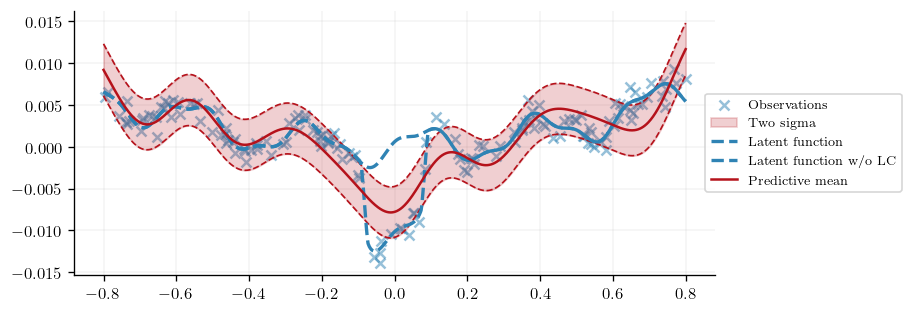

In [35]:
latent_dist = sparse_model(t.reshape(-1, 1), train_data=data)
predictive_dist = sparse_model.posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.scatter(t_train, lc_train, label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    t,
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    t,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    t,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    t,
    lightcurve + systematics,
    label="Latent function",
    color=cols[0],
    linestyle="--",
    linewidth=2,
)
ax.plot(
    t,
    systematics,
    label="Latent function w/o LC",
    color=cols[0],
    linestyle="--",
    linewidth=2,
)
ax.plot(t, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))